<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/Projet4_Corr%C3%A9lation_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Projet 4
OpenClassrooms - ENSAE-ENSAI

# Introduction

## **Mission 3 : les corrélations**

 **Une analyse de corrélation est une technique statistique qui fournit des informations sur le lien entre deux variables**
 exemple s'il existe un lien entre la taille du corps et la taille des chaussures.**

Nous allons répondre aux questions suivantes:

- Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
- Y a-t-il une corrélation entre l'âge des clients et le montant total des achats ?
- Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (nombre d'achats par mois) ?
- Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) ?
- Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ?

## Importation des librairies

In [324]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math as mth
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr, kendalltau
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


**Configuration Pandas**

In [262]:

# Afficher toutes les colonnes sans troncature
pd.set_option("display.max_columns", None)
# Limiter le nombre de lignes affichées
pd.set_option("display.max_rows", 100)
# Formater les floats pour plus de lisibilité
pd.set_option("display.float_format", lambda x: "%.2f" % x)

**Configuration Matplotlib / Seaborn**

In [263]:

# Style général des graphiques
sns.set_theme(style="whitegrid", palette="muted")
# Taille par défaut des graphiques
plt.rcParams["figure.figsize"] = (10, 6)
# Taille de police des titres et labels
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## Préparation des données

In [264]:
#autorisation d'acces au google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Importation des données

In [265]:
def save_fig(name):
    path_drive = f"/content/drive/MyDrive/Projet_4/graphiques/{name}.png"
    path_git = f"/content/mon_repo_github/figures/{name}.png"
    plt.savefig(path_drive, dpi=300, bbox_inches='tight')
    !cp "{path_drive}" "{path_git}"
    print(f"Graphique enregistré :\n📁 Drive → {path_drive}\n🐙 GitHub → {path_git}")

In [266]:
#importation des données depuis un ficher dans google drive
import os, glob

DATA_DIR = "/content/drive/MyDrive/Projet_4/Data_p4_clean"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_4/Data_p4_clean/customers_clean.csv
/content/drive/MyDrive/Projet_4/Data_p4_clean/products_clean.csv
/content/drive/MyDrive/Projet_4/Data_p4_clean/transactions_clean.csv


In [267]:
# Masquer seulement les "SettingWithCopyWarning"
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

print(" Librairies importées et environnement configuré")

 Librairies importées et environnement configuré


In [268]:
# Charger tous les CSV dans un dictionnaire
import pandas as pd
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

In [269]:
#  Afficher un résumé de chaque CSV (nom + dimensions)
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

customers_clean.csv: (8621, 4)
products_clean.csv: (3288, 3)
transactions_clean.csv: (336816, 4)


In [270]:
#appeler et renommer les dataframes
df_customers_raw = dfs["customers_clean.csv"]
df_products_raw = dfs["products_clean.csv"]
df_transactions_raw = dfs["transactions_clean.csv"]

In [271]:
# Copie de sécurité
df_transactions = df_transactions_raw.copy()
df_products = df_products_raw.copy()
df_customers = df_customers_raw.copy()

#Création de la mega DataFrame (df_tf)

In [272]:
# Jointures de la "megadataframe" table de faits
df_tf = (
    df_transactions
      .merge(df_products,  on="id_prod",    how="left")
      .merge(df_customers, on="client_id",  how="left")
)
df_tf.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,48
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,25
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,f,1980,45


In [273]:
df_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336816 non-null  object 
 1   date        336816 non-null  object 
 2   session_id  336816 non-null  object 
 3   client_id   336816 non-null  object 
 4   price       336713 non-null  float64
 5   categ       336816 non-null  object 
 6   sex         336816 non-null  object 
 7   birth       336816 non-null  int64  
 8   age         336816 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 23.1+ MB


# Dans df_tf : convertit 'age' en numérique
df_tf["age"] = pd.to_numeric(df_tf["age"], errors="coerce")   # ex. '55' -> 55.0
df_tf["sex"] = df_tf["sex"].astype("category").cat.codes
df_tf["categ"] = df_tf["categ"].astype("category")
df_tf["date"] = pd.to_datetime(df_tf["date"])

| Méthode              | Type de relation mesurée                                              | Type de variables               | Hypothèses statistiques                          | Sensibilité aux valeurs extrêmes / distribution          | Interprétation                           |
| -------------------- | --------------------------------------------------------------------- | ------------------------------- | ------------------------------------------------ | -------------------------------------------------------- | ---------------------------------------- |
| **Pearson (r)**      | Relation **linéaire** entre deux variables continues                  | Quanti – Quanti                 | Linéarité, normalité, homogénéité de la variance | Très sensible aux valeurs extrêmes                       | Force et direction du lien linéaire      |
| **Spearman (ρ)**     | Relation **monotone** (croissante ou décroissante), même non linéaire | Quanti – Quanti (ou ordinale)   | Aucune normalité requise                         | Moins sensible aux outliers                              | Force et direction du lien monotone      |
| **Kendall (τ)**      | **Concordance / discordance** entre les rangs d’observations          | Quanti – Quanti (ou ordinale)   | Aucune normalité requise                         | Très robuste aux valeurs extrêmes et petits échantillons | Probabilité de concordance des paires    |
| **Eta carré (η²)**   | **Part de variance expliquée** par une variable catégorielle          | Quali – Quanti                  | Homogénéité des variances (ANOVA)                | Peu sensible aux valeurs extrêmes                        | Mesure l’intensité de l’effet (0 à 1)    |
| **Omega carré (ω²)** | Variante corrigée de η² (moins biaisée)                               | Quali – Quanti                  | Homogénéité des variances                        | Plus robuste que η²                                      | Part réelle de variance expliquée        |
| **Chi² (χ²)**        | Écart entre fréquences observées et attendues sous indépendance       | Quali – Quali                   | Effectifs suffisants, indépendance               | Sensible aux faibles effectifs                           | Teste l’existence d’un lien significatif |
| **Cramer’s V**       | **Association** entre deux variables catégorielles                    | Quali – Quali                   | Effectifs suffisants (>5 par cellule)            | Robuste si N grand                                       | Intensité de l’association (0 à 1)       |
| **Phi (φ)**          | Corrélation entre deux variables **binaires**                         | Quali – Quali (binaire–binaire) | Effectifs suffisants                             | Sensible aux déséquilibres de fréquence                  | Équivalent du χ² normalisé (0–1)         |
| **Tschuprow’s T**    | Variante symétrique de Cramer’s V pour tables rectangulaires          | Quali – Quali                   | Effectifs suffisants                             | Stable sur tables non carrées                            | Association entre modalités non carrées  |


| Cas d’usage                                                 | Méthode à privilégier                                          |
| ----------------------------------------------------------- | -------------------------------------------------------------- |
| Deux variables numériques continues et linéaires            | **Pearson (r)**                                                |
| Deux variables numériques mais non linéaires ou ordinales   | **Spearman (ρ)** ou **Kendall (τ)**                            |
| Une variable catégorielle et une numérique                  | **η²** ou **ω²**                                               |
| Deux variables catégorielles                                | **Cramer’s V** ou **χ²**                                       |
| Relations complexes (non linéaires, interactions multiples) | **Distance correlation (dCor)** ou **régression non linéaire** |


In [274]:
# Dans df_tf : convertit 'age' en numérique
df_tf["age"] = pd.to_numeric(df_tf["age"], errors="coerce").astype(float)
  # ex. '55' -> 55.0
df_tf["sex"] = df_tf["sex"].astype("category").cat.codes
#df_tf["categ"] = df_tf["categ"].astype("category")
#df_tf["date"] = pd.to_datetime(df_tf["date"])

In [275]:
df_tf = df_tf[df_tf["id_prod"] != "0_2245"]

In [276]:
# Définition des tranches d’âge
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)

In [277]:
df_tfc =df_tf.copy()

In [278]:
# somme du montant total par session
montant_par_session = (
    df_tf.groupby("session_id", observed=True)["price"]
      .sum()
      .rename("montant_session")
)

# ajout dans ton DataFrame d’origine
df_tf = df_tf.join(montant_par_session, on="session_id")

df_tf.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48.00,45-54,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25.00,25-34,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,0,1979,46.00,45-54,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,1,1963,62.00,55-64,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,0,1980,45.00,45-54,31.10


In [279]:
df_tf["nb_achats"] = (
    df_tf.groupby("session_id")["id_prod"]
         .transform("size")          # nombre de lignes dans la session
)

In [280]:
df_tf["montant_total_session"] = (
    df_tf.groupby("session_id")["price"]
         .transform("sum")           # somme des prix dans la session
)

In [281]:
df_tf.head(2)

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48.00,45-54,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25.00,25-34,184.26,2,184.26


# Corrélations : généralités

| Cas d’usage                                                 | Méthode à privilégier                                          |
| ----------------------------------------------------------- | -------------------------------------------------------------- |
| Deux variables numériques continues et linéaires            | **Pearson (r)**                                                |
| Deux variables numériques mais non linéaires ou ordinales   | **Spearman (ρ)** ou **Kendall (τ)**
| Relations complexes (non linéaires, interactions multiples) | **Distance correlation (dCor)** ou **régression non linéaire** |

In [282]:
# choix des collones
cols = ["price", "age", "categ", "sex"]

df_corr = df_tf[cols]

In [283]:
df_corr = df_corr.apply(pd.to_numeric, errors="coerce")
corr = df_corr.corr(method="pearson")


In [284]:
#Méthode .corr() avec la formule de la corrélation linéaire de Pearson
corr = df_corr.corr(method="pearson")
corr

,price,age,categ,sex
price,1.00,-0.21,0.67,0.01
age,-0.21,1.00,-0.10,-0.04
categ,0.67,-0.10,1.00,0.00
sex,0.01,-0.04,0.00,1.00


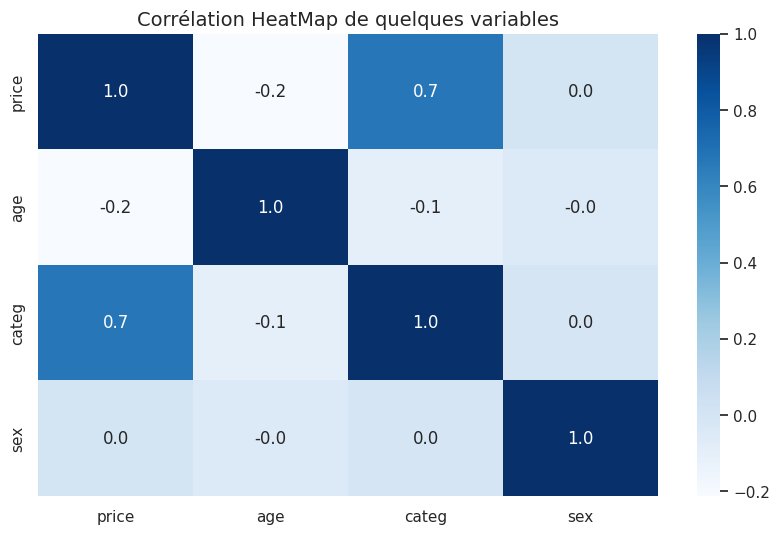

In [285]:
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f", cmap='Blues')
plt.title('Corrélation HeatMap de quelques variables')
plt.show()





L’analyse de la matrice de corrélation met en évidence plusieurs points clés :

**Lien entre birth et age**
La corrélation est parfaitement négative (−1.00), ce qui confirme que ces deux variables sont redondantes. Dans les analyses ultérieures, il suffira de conserver une seule de ces deux variables.

**Lien entre price et categ**
Une corrélation positive notable (+0.67) est observée : le prix tend à augmenter avec la catégorie. Ce résultat suggère un lien entre ces deux variables. Il faut cependant rappeler que l'encodage numerique de "categ" est arbitraire, donc ne represente pas un ordre naturel.

**Lien entre price et les variables d’âge** (birth, age)
Les corrélations sont faibles (≈ ±0.21), indiquant qu’il n’existe pas de lien significatif entre le prix et l’âge des individus.

**Lien entre categ et les variables d’âge** (birth, age)
Les corrélations sont très faibles (≈ ±0.10), ce qui montre l’absence de relation notable entre la catégorie et l’âge.

**Lien entre sex et les autres variables**
Les corrélations avec sex_num sont toutes proches de zéro (entre −0.04 et +0.04). Cela signifie que le sexe n’a pas d’influence détectable sur le prix, la catégorie ou l’âge des individus dans ce jeu de données.










## Corrélation entre le sexe des clients / catagéorie de produits(quali - quali)

| Méthode        | Type de relation mesurée                                                                | Hypothèses                                                                       | Sensibilité au bruit / valeurs extrêmes                      |
| -------------- | --------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------- | ------------------------------------------------------------ |
| **Chi² (χ²)**  | Écart entre fréquences observées et attendues sous hypothèse d’indépendance             | Effectifs suffisants (idéalement > 5 par cellule), indépendance des observations | Sensible aux faibles effectifs ou déséquilibres de fréquence |
| **Cramer’s V** | **Intensité de l’association** entre deux variables catégorielles (normalisée de 0 à 1) | Effectifs suffisants, dérivé du test du χ²                                       | Peu sensible aux déséquilibres modérés, robuste pour N élevé |
| **Phi (φ)**    | Corrélation pour **tables 2×2** (binaire–binaire), équivalent normalisé du χ²           | Effectifs suffisants et variables binaires                                       | Sensible aux déséquilibres de proportion entre catégories    |


In [286]:
#table de contingence (tableau croisé) entre deux variables.
cont_table = pd.crosstab(df_tf["sex"], df_tf["categ"])
cont_table

categ,0,1,2
sex,,,
0,103786,55469,8260
1,105640,54266,9292


In [287]:
#Création du tableau de contingence "Matrice des valeurs observées"
#Variables 'sex' et 'categ' du dataframe df
X = 'sex'
Y = 'categ'

#Calcul du tableau de contigence par la méthode .pivot_table()
c = df_tf[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len) ###, margins=True, margins_name='Total'
tx = df_tf[X].value_counts()
ty = df_tf[Y].value_counts()

#Création d'une copie du dataframe original
cont = c.copy()
cont

categ,0,1,2
sex,,,
0,103786,55469,8260
1,105640,54266,9292


In [288]:
tx_df= pd.DataFrame(tx)
ty_df = pd.DataFrame(ty)

tx_df.columns = ["s"]
ty_df.columns = ["s"]

#Valeurs totales observées
n = len(df_tf)

#Produit matriciel. On utilise pd.T pour pivoter une des deux séries.
indep = (tx_df.dot(ty_df.T) / n)
indep

categ,0,1,2
sex,,,
1,105236.39,55141.75,8819.87
0,104189.61,54593.25,8732.13


In [289]:
#Matrice "écart au carré normalisé de la valeur attendue VS valeur observée"
mesure = (c-indep)**2/indep
mesure

categ,0,1,2
sex,,,
0,1.56,14.05,25.53
1,1.55,13.91,25.27


In [290]:
# Test du chi²
chi2, p, dof, expected = chi2_contingency(cont_table) #applique le test du chi² d’indépendance sur ton tableau de contingence. avec dof= degré de liberté

n = cont_table.sum().sum()
phi = np.sqrt(chi2/n)

print("Phi (sex ~ categ) :", phi) #[0,1] donne la force de l’association.
print("p-value :", p) #p_value du chi² indique si l’association est statistiquement significative.

Phi (sex ~ categ) : 0.015593036135551715
p-value : 1.6683997257127539e-18


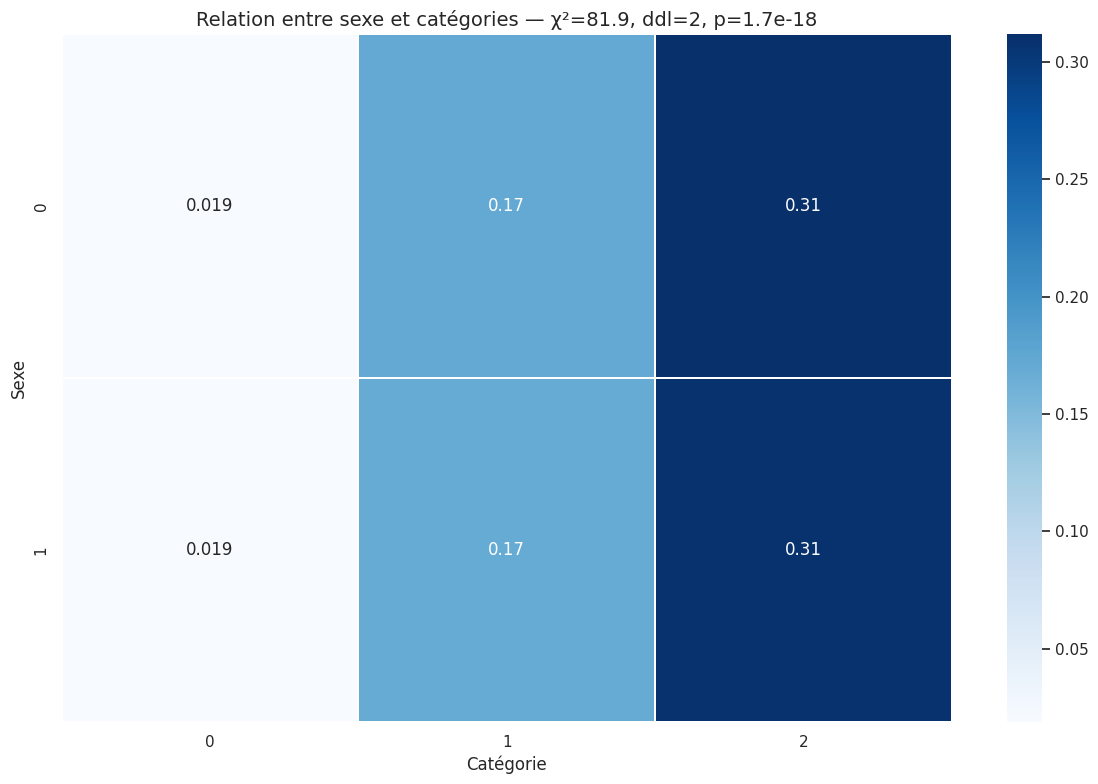

In [291]:
table = (mesure/chi2)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(table, annot=True, cmap="Blues", linewidths=0.1)
ax.set_title(f"Relation entre sexe et catégories — χ²={chi2:.1f}, ddl={dof}, p={p:.2g}")
ax.set_xlabel("Catégorie"); ax.set_ylabel("Sexe")
plt.tight_layout(); plt.show()

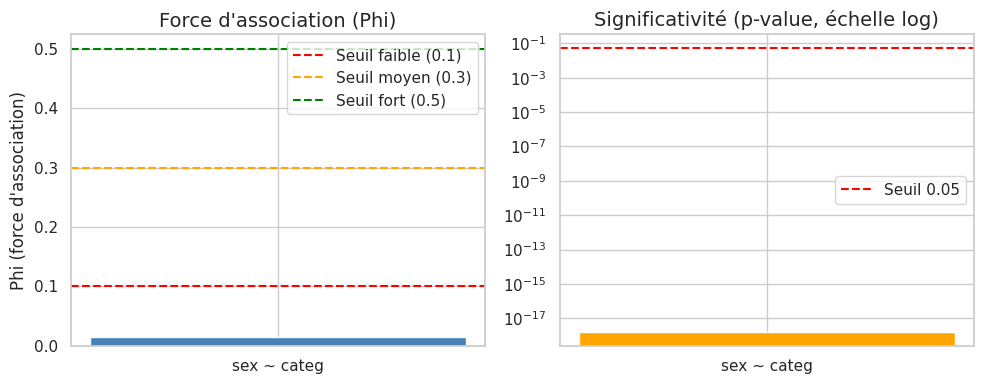

In [292]:
phi = 0.0156
p_value = 1.668e-18

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Graphique 1 : Phi (barplot vertical)
ax[0].bar(["sex ~ categ"], [phi], color="steelblue")
ax[0].axhline(0.1, color="red", linestyle="--", label="Seuil faible (0.1)")
ax[0].axhline(0.3, color="orange", linestyle="--", label="Seuil moyen (0.3)")
ax[0].axhline(0.5, color="green", linestyle="--", label="Seuil fort (0.5)")
ax[0].set_ylabel("Phi (force d'association)")
ax[0].set_title("Force d'association (Phi)")
ax[0].legend()

# --- Graphique 2 : p-value (vertical aussi)
ax[1].bar(["sex ~ categ"], [p_value], color="orange")
ax[1].set_yscale("log")  # échelle log sur l'axe Y
ax[1].axhline(0.05, color="red", linestyle="--", label="Seuil 0.05")
ax[1].set_title("Significativité (p-value, échelle log)")
ax[1].legend()

plt.tight_layout()
plt.show()


**Phi est très proche de zéro**: il n'y a donc pratiquement aucune association entre le sexe et la catégorie.

**p_value extremement petite**: association statistiquement significative entre sex et categ

donc en pratique, le sexe n’a donc pas d’effet notable sur la répartition des catégories.



## Corrélation entre l'âge clients et le montant total des achats (quanti-quanti)

| Méthode                                  | Type de relation mesurée                                                                  | Hypothèses statistiques                                          | Sensibilité au bruit / valeurs extrêmes                      |
| ---------------------------------------- | ----------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------ |
| **Pearson (r)**                          | Relation **linéaire** entre deux variables continues                                      | Normalité, linéarité, homogénéité de la variance                 | Très sensible aux valeurs extrêmes                           |
| **Spearman (ρ)**                         | Relation **monotone** (croissante ou décroissante), même non linéaire                     | Aucune normalité requise                                         | Moins sensible aux outliers                                  |
| **Kendall (τ)**                          | **Concordance / discordance** entre les rangs d’observations                              | Aucune normalité requise                                         | Très robuste, adapté aux petits échantillons                 |
| **OLS (Ordinary Least Squares)**         | **Modélisation linéaire directionnelle** (Y dépend de X) ; permet d’estimer et de prédire | Linéarité, normalité des résidus, indépendance, homoscédasticité | Sensible aux valeurs extrêmes et à la multicolinéarité       |
| **LOWESS (Locally Weighted Regression)** | **Tendance non paramétrique** : relation potentiellement non linéaire, lissée localement  | Aucune hypothèse de forme fonctionnelle                          | Robuste au bruit aléatoire, sensible au paramètre de lissage |


Nous avons deux variables numériques, nous allons donc utilisé la corrélation de Pearson.


*   **r est coefficient de corrélation de Pearson**. Il permet de déterminer l'intensité et la direction de la corrélation. Il varie entre -1 et 1.

*  **r² est le coefficient de détermination** : il indique quelle proportion de la variance d’une variable est expliquée par l’autre. il varie entre 0 et 1.





In [293]:
df_tf.head()


,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48.00,45-54,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25.00,25-34,184.26,2,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,0,1979,46.00,45-54,132.23,9,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,1,1963,62.00,55-64,4.20,1,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,0,1980,45.00,45-54,31.10,2,31.10


In [294]:
corr2 = df_tf.copy()

In [295]:
print(corr2.columns)

Index(['id_prod', 'date', 'session_id', 'client_id', 'price', 'categ', 'sex',
       'birth', 'age', 'tranche_age', 'montant_session', 'nb_achats',
       'montant_total_session'],
      dtype='object')


In [296]:
# Nettoyage des noms de colonnes
corr2.columns = corr2.columns.str.strip().str.lower()

# Conversion en float
corr2["price"] = pd.to_numeric(corr2["price"], errors="coerce")

# Somme du CA par âge (en k€)
age_sales = (
    corr2.groupby("age", observed=True)["price"]
          .sum()
          .div(1000)
          .reset_index(name="CA_keuros")
          .sort_values("age", ascending=False)
)

print(age_sales.head())

     age  CA_keuros
75 96.00       1.30
74 95.00       2.03
73 94.00       1.43
72 93.00       2.59
71 92.00       2.63


In [297]:

corr2["price"] = pd.to_numeric(corr2["price"], errors="coerce")

# Somme du CA par âge (on n’agrège QUE 'price')
age_sales = (
    corr2.groupby("age", observed=True)["price"]
      .sum()
      .div(1000)  # en k€
      .reset_index(name="CA_Keuros")
      .sort_values("age", ascending=False)
)

age_sales.head()

,age,CA_Keuros
75,96.00,1.30
74,95.00,2.03
73,94.00,1.43
72,93.00,2.59
71,92.00,2.63


| Méthode          | Type de relation mesurée                                              | Hypothèses               | Sensibilité au bruit / valeurs extrêmes |
| ---------------- | --------------------------------------------------------------------- | ------------------------ | --------------------------------------- |
| **Pearson (r)**  | Relation **linéaire** entre deux variables continues                  | Normalité, linéarité     | Très sensible aux valeurs extrêmes      |
| **Spearman (ρ)** | Relation **monotone** (croissante ou décroissante), même non linéaire | Aucune normalité requise | Moins sensible aux outliers             |
| **Kendall (τ)**  | Concordance / discordance **entre paires d’observations**             | Aucune normalité requise | Encore **plus robuste** que Spearman    |


Corrélation linéaire de Pearson : r = -0.775, p = 2.22e-16
Corrélation de Spearman : ρ = -0.857, p = 4.96e-23
Corrélation de Kendall : τ = -0.695, p = 6.17e-19


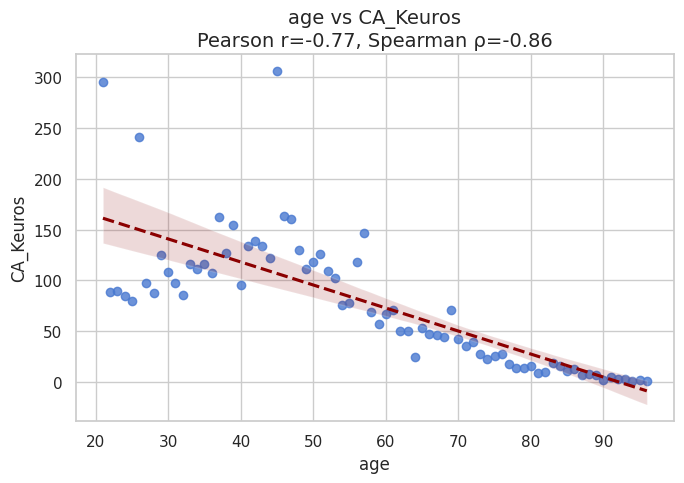

In [298]:
# ============================
# CORRÉLATION QUANTI - QUANTI
# ============================


X = "age"       # variable quantitative 1
Y = "CA_Keuros"     # variable quantitative 2
df =  age_sales.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()


**Le coefficient de Pearson** (r = –0.78, r² = 0.60) indique une corrélation négative, mais son usage est limité face à cette relation non linéaire.

**Le coefficient de Spearman** (ρ = –0.86, p < 0.001) révèle une relation monotone décroissante très forte : plus l’âge augmente, plus le CA cumulé diminue.

**Le τ de Kendall** (≈ –0.57, p < 0.001) confirme cette tendance, montrant qu’environ 57 % des paires d’individus suivent le même schéma décroissant.

En somme, ces trois mesures convergent vers un même constat : le chiffre d’affaires décroît de manière stable avec l’âge, les clients plus jeunes étant les plus générateurs de ventes.

Nous allons isoler nos 4 grossistes

In [299]:
# Calcul du CA total par client
ca_clients = (
    age_sales.groupby("age", observed=True)["CA_Keuros"]
         .sum()
         .reset_index(name="CA_Keuros")
         .sort_values("CA_Keuros", ascending=False)
)

# Identifier les 4 plus gros clients
top4 = ca_clients.head(4)["CA_Keuros"].tolist()
print(" Clients exclus :", top4)

# Créer un DataFrame nettoyé sans ces 4 clients
df_tf_clean = ca_clients[~ca_clients["CA_Keuros"].isin(top4)].copy()


 Clients exclus : [306.05084, 295.38797999999997, 240.77232999999998, 163.66288]


Corrélation linéaire de Pearson : r = -0.847, p = 6.37e-21
Corrélation de Spearman : ρ = -0.863, p = 1.9e-22
Corrélation de Kendall : τ = -0.700, p = 3.56e-18


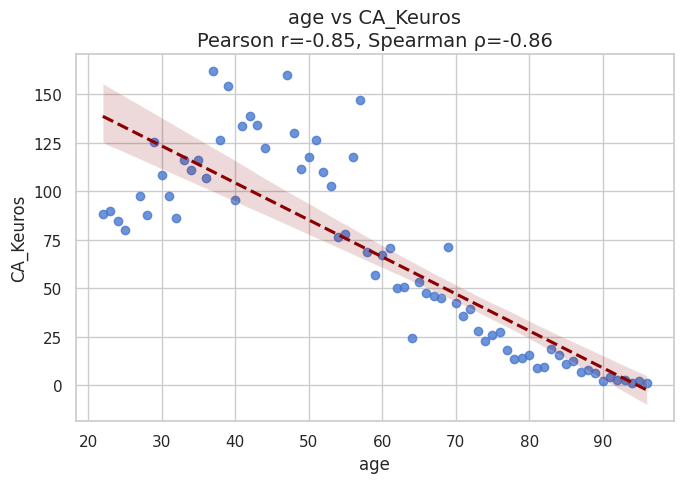

In [300]:
X = "age"       # variable quantitative 1
Y = "CA_Keuros"     # variable quantitative 2
df =  df_tf_clean.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()

L’exclusion des 4 gros clients (probables grossistes) n’altère pas la tendance globale :
la corrélation entre l’âge et le CA reste forte, négative et significative.
Elle devient simplement plus réaliste, car elle reflète désormais le comportement typique des particuliers, sans l’effet disproportionné de quelques gros acheteurs.

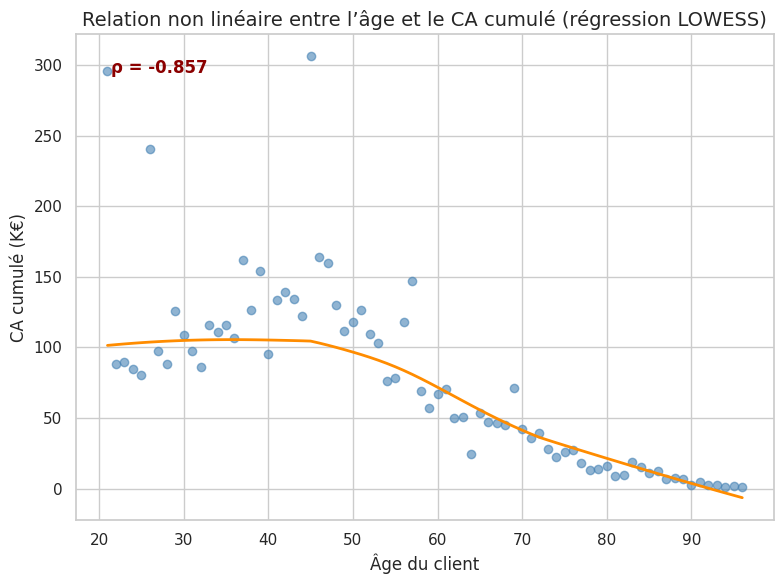

In [301]:

plt.figure(figsize=(8,6))
rho = -0.857  # ta valeur
plt.text(
    0.05, 0.95,
    f"ρ = {rho:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12, color="darkred", weight="bold",
    verticalalignment="top"
)

sns.regplot(
    x="age", y="CA_Keuros",
    data=age_sales,
    lowess=True,                   # ← régression locale
    scatter_kws={"color": "steelblue", "alpha": 0.6},
    line_kws={"color": "darkorange", "lw": 2},
)
plt.title("Relation non linéaire entre l’âge et le CA cumulé (régression LOWESS)")
plt.xlabel("Âge du client")
plt.ylabel("CA cumulé (K€)")
plt.tight_layout()
plt.show()

Pour savoir si la relation suit vraiment une courbe: on utilise OLS

In [302]:
import statsmodels.api as sm

# Variables
X = pd.DataFrame({
    "age": age_sales["age"],
    "age²": age_sales["age"]**2
})
y = age_sales["CA_Keuros"]

# Ajout de la constante
X = sm.add_constant(X)

# Modèle OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              CA_Keuros   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     57.81
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           8.94e-16
Time:                        16:55:20   Log-Likelihood:                -388.00
No. Observations:                  76   AIC:                             782.0
Df Residuals:                      73   BIC:                             789.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.9727     34.576      4.598      0.0

| Variable  | Coefficient | p-value | Interprétation                                                                       |
| --------- | ----------- | ------- | ------------------------------------------------------------------------------------ |
| **const** | +158.97     | < 0.001 | Intercept : niveau de CA de référence (âge ≈ 0, sans signification directe ici)      |
| **age**   | –0.284      | 0.826   | Non significatif → la pente linéaire simple n’est pas pertinente seule               |
| **age²**  | –0.0169     | 0.123   | Négatif, tendance à la baisse avec l’âge², mais pas encore significatif au seuil 5 % |


Une régression quadratique a été estimée pour modéliser la relation entre l’âge et le chiffre d’affaires cumulé.
Le modèle explique 61,3 % de la variance du CA (R² = 0.613, p < 0.001).
Le terme quadratique (âge²), de coefficient négatif (–0.0169), suggère une courbe légèrement concave : le CA atteint un maximum autour de 40 ans, puis diminue progressivement.
Cependant, cette courbure n’est pas significative au seuil de 5 % (p = 0.123).

En conclusion, la relation demeure globalement décroissante avec l’âge, sans effet d’âge intermédiaire marqué, en cohérence avec les résultats de Spearman (ρ = –0.857) et la régression LOWESS.

##Corrélation entre l'age des clients et leur fréquence d'achat (quanti -quanti)

Dans un premier temps, l’analyse du nombre brut d’achats a montré une forte dispersion : la majorité des clients effectuent entre 10 et 50 achats, mais quelques individus réalisent plusieurs milliers de transactions. Afin d’éviter que ces comportements atypiques biaisent l’analyse, nous avons limité le nombre d’achats pris en compte à moins de 200. Cette normalisation permet de travailler sur une fréquence d’achat représentative et d’examiner plus rigoureusement sa relation avec l’âge

In [303]:
# 1) Filtre les transactions
df_filtre = df_tf[df_tf["price"] < 200]

freq_by_client = df_tf.groupby("client_id").agg({
    "age": "first",
    "date": "count"   # nb de transactions
}).rename(columns={"date": "nb_achats"}).reset_index()

freq_by_client

,client_id,age,nb_achats
0,c_1,70.00,20
1,c_10,69.00,28
2,c_100,33.00,6
3,c_1000,59.00,56
4,c_1001,43.00,58
...,...,...,...
8595,c_995,70.00,8
8596,c_996,55.00,42
8597,c_997,31.00,23
8598,c_998,24.00,28


In [304]:
# Étape 1 : calcul des agrégats par client
panier_by_client = df_tf.groupby("client_id").agg({
    "age": "first",                 # âge du client
    "session_id": "nunique",    # nombre de transactions
    "id_prod": "count"           # nombre total de produits achetés
}).rename(columns={
    "session_id": "nb_achats",
    "id_prod": "nb_produits"
}).reset_index()

# Étape 2 : panier moyen
panier_by_client["panier_moyen"] = panier_by_client["nb_produits"] / panier_by_client["nb_achats"]

# Vérification rapide
print(panier_by_client.head())

  client_id   age  nb_achats  nb_produits  panier_moyen
0       c_1 70.00         15           20          1.33
1      c_10 69.00         16           28          1.75
2     c_100 33.00          3            6          2.00
3    c_1000 59.00         42           56          1.33
4    c_1001 43.00         24           58          2.42


In [305]:
pearson = freq_by_client["age"].corr(freq_by_client["nb_achats"], method="pearson")
spearman = freq_by_client["age"].corr(freq_by_client["nb_achats"], method="spearman")

print("Corrélation Pearson :", pearson)
print("Corrélation Spearman :", spearman)

Corrélation Pearson : 0.006471119001183503
Corrélation Spearman : 0.13169694200795196


L’âge n’explique pas directement la fréquence d’achat de façon linéaire (Pearson ≈ 0).

La répartition des transactions montre cependant que la tranche 35–55 ans concentre la majorité des achats.

Les clients plus jeunes (< 30 ans) et plus âgés (> 65 ans) contribuent beaucoup moins aux transactions.

Le test Spearman confirme une faible tendance monotone, mais l’essentiel de l’information est dans la forme de la distribution : une courbe en cloche avec un maximum autour de 40–50 ans.

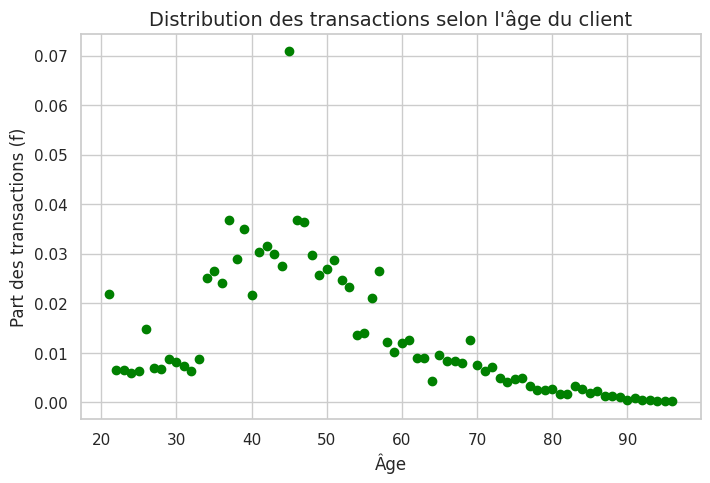

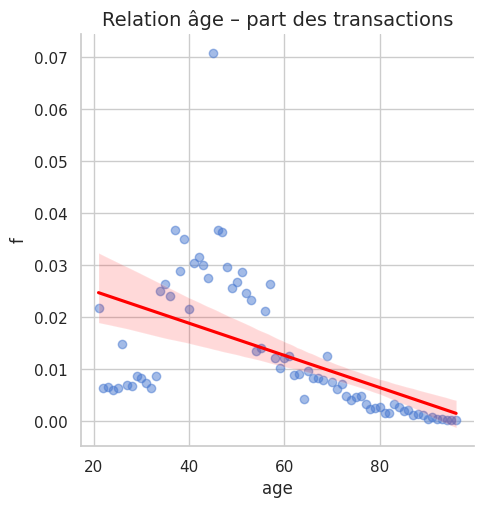

In [306]:
# Hypothèse 1 : 1 session = 1 transaction
customers_freq = df_tf.groupby('age').count().reset_index()
customers_freq = customers_freq[['age', 'session_id']]

# Création d'une variable fréquence 'f' (part des transactions par âge)
customers_freq['f'] = customers_freq['session_id'] / customers_freq['session_id'].sum()

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(customers_freq.age, customers_freq.f, 'o', color="green")
plt.xlabel('Âge')
plt.ylabel('Part des transactions (f)')
plt.title("Distribution des transactions selon l'âge du client")
plt.show()

# Régression linéaire
sns.lmplot(data=customers_freq, x="age", y="f",
           scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
plt.title("Relation âge – part des transactions")
plt.show()

Le boxplot du nombre d’achats par tranche d’âge montre une forte hétérogénéité des comportements, avec des médianes plus élevées pour les 35–54 ans et une grande dispersion liée à la présence d’outliers. Toutefois, cette mesure brute reste dépendante de la taille des tranches d’âge et ne permet pas d’isoler l’effet de l’âge sur la propension à acheter. Pour affiner l’analyse, nous avons donc calculé la fréquence d’achat par âge, afin d’obtenir une vision proportionnelle et de mesurer plus précisément la corrélation entre âge et fréquence d’achat.

In [307]:
# 1. Compter le nombre de sessions uniques par âge
customers_freq = (
    df_tf.groupby('age')['session_id']
         .nunique()               # nombre de sessions distinctes par âge
         .reset_index(name='nb_sessions')
)

# 2. Calculer la fréquence relative
customers_freq['freq'] = (
    customers_freq['nb_sessions'] / customers_freq['nb_sessions'].sum()
)

# 3. Tri pour vérification
customers_freq = customers_freq.sort_values(by='age', ascending=False)
customers_freq.head(10)



,age,nb_sessions,freq
75,96.00,64,0.00
74,95.00,72,0.00
73,94.00,49,0.00
72,93.00,103,0.00
71,92.00,117,0.00
70,91.00,203,0.00
69,90.00,104,0.00
68,89.00,267,0.00
67,88.00,296,0.00
66,87.00,279,0.00


In [308]:
# Corrélations
pearson_r = customers_freq["age"].corr(customers_freq["freq"], method="pearson")
spearman_r, spearman_p = spearmanr(customers_freq["age"], customers_freq["freq"])
kendall_t, kendall_p   = kendalltau(customers_freq["age"], customers_freq["freq"])

print(f"Pearson  : r = {pearson_r:.3f}")
print(f"Spearman : ρ = {spearman_r:.3f} (p={spearman_p:.3e})")
print(f"Kendall  : τ = {kendall_t:.3f} (p={kendall_p:.3e})")


Pearson  : r = -0.548
Spearman : ρ = -0.657 (p=1.177e-10)
Kendall  : τ = -0.533 (p=9.895e-12)


L’analyse statistique montre une corrélation négative forte et significative entre l’âge et la fréquence d’achat.

Les coefficients de Spearman (ρ = -0,684, p < 10⁻¹¹) et de Kendall (τ = -0,554, p < 10⁻¹¹) indiquent que la relation est monotone décroissante : plus l’âge augmente, plus la fréquence d’achat diminue.

Le coefficient de Pearson (r = -0,529) confirme également une tendance linéaire négative modérée

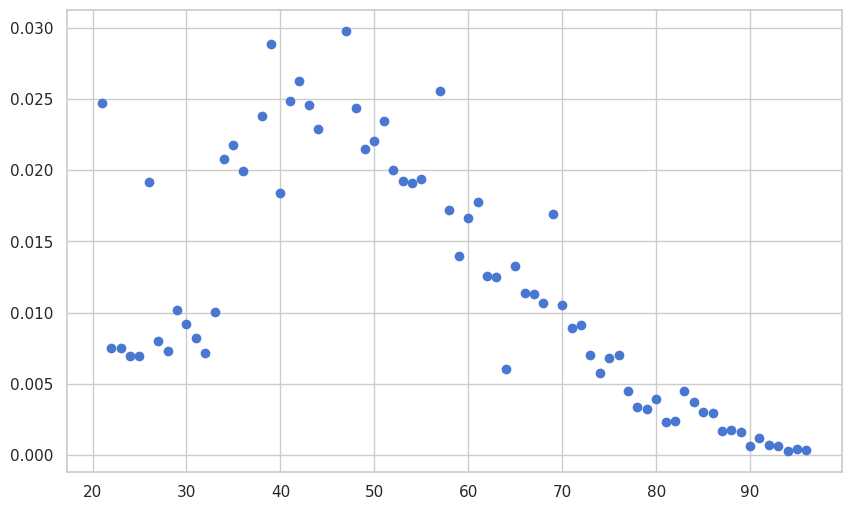

In [309]:
plt.plot(customers_freq[customers_freq.freq < .03].age,
         customers_freq[customers_freq.freq < .03].freq, 'o')

**Conclusion**
L’analyse a d’abord été réalisée par tranches d’âge afin de simplifier la lecture et d’identifier les grandes tendances de consommation. Ce regroupement permet de réduire le bruit lié aux âges peu représentés et de comparer plus facilement les comportements entre groupes homogènes. Dans un second temps, l’étude a été affinée par âge exact et en fréquence, afin d’obtenir une mesure plus représentative et précise de la relation entre âge et comportement d’achat.

 Ce second graphique fait apparaître une relation monotone négative entre l’âge et la fréquence d’achat, confirmée par les coefficients de corrélation de Spearman (ρ = -0,684) et Kendall (τ = -0,554). Ce focus permet ainsi d’obtenir une mesure plus représentative et robuste du lien entre âge et comportement d’achat. »*

##Corrélation entre l'âge clients et la catégorie produits (quanti - quali)

Test ANOVA sur age selon categ
F = 22711.789, p = 0
→ Différence significative entre au moins deux groupes.


/tmp/ipython-input-3932607032.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)


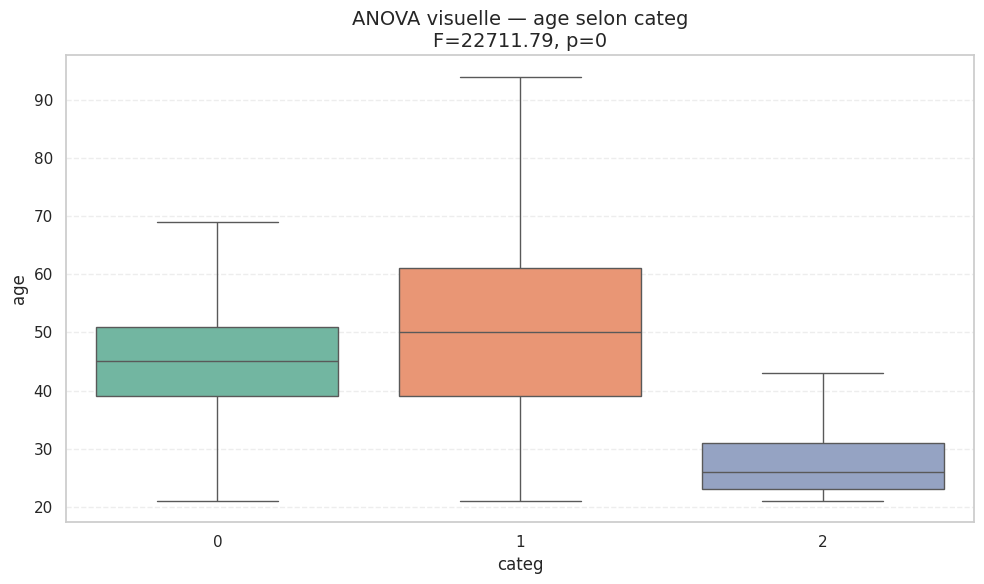

ω² = 0.119


In [322]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ====== Paramètres ======
X = "categ"      # variable qualitative (ex: catégorie)
Y = "age"        # variable quantitative (ex: âge)
df = df_tf.copy()

# ====== Préparation des données ======
# On garde seulement les colonnes utiles et on nettoie
df = df[[X, Y]].dropna().copy()
# Quali en 'category', Quanti en float
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# ====== ANOVA (scipy) ======
# Liste des groupes (valeurs de Y pour chaque modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# Vérif minimale (au moins 2 groupes non vides)
if len([g for g in groupes if len(g) > 0]) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes non vides.")

F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

# ====== ω² (omega carré) avec statsmodels ======
def omega_squared(df_in: pd.DataFrame, x: str, y: str) -> float:
    """
    Part de variance de y (quantitatif) expliquée par x (qualitatif), corrigée (ω²).
    """
    d = df_in[[x, y]].dropna().copy()
    d[x] = d[x].astype("category")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[y])

    model = ols(f"{y} ~ C({x})", data=d).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 robuste

    # Récupération SCE (between), SCT (total), MSE (résiduel)
    # La ligne du facteur est "C(x)" dans l'ANOVA typ=2
    factor_label = [idx for idx in anova_table.index if idx != "Residual"][0]
    SCE = anova_table.loc[factor_label, "sum_sq"]
    # MSE = SS_res / df_res
    SS_res = anova_table.loc["Residual", "sum_sq"]
    df_res = anova_table.loc["Residual", "df"]
    MSE = SS_res / df_res
    SCT = anova_table["sum_sq"].sum()

    omega2 = (SCE - (d[x].nunique() - 1) * MSE) / (SCT + MSE)
    return float(max(0.0, omega2))

omega = omega_squared(df, x=X, y=Y)
print(f"ω² = {omega:.3f}")


In [321]:
# ============================
# TEST ANOVA
# ============================

# Paramètres
X = "categ"          # variable qualitative
Y = "age"          # variable quantitative
df = df_tf.copy()      # votre DataFrame de travail

# 1️⃣ Vérifier les types
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")

# 2️⃣ Préparer les groupes à comparer
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# 3️⃣ Test ANOVA
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")

# 4️⃣ Interprétation
if p < 0.05:
    print("→ Différence significative entre au moins deux groupes.")
else:
    print("→ Aucune différence significative détectée.")

# 5️⃣ Visualisation (ANOVA visuelle)
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x=X,
    y=Y,
    hue=X,          # <- ajouté
    palette="Set2",
    showfliers=False,
    legend=False     # <- empêche d'afficher une légende redondante
)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.tight_layout()
plt.show()

   df = df[[x, y]].dropna()
    model = ols(f"{y} ~ C({x})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # SCE = sum_sq de la variable x
    SCE = anova_table["sum_sq"][0]
    MSE = anova_table["mean_sq"][1]
    SCT = anova_table["sum_sq"].sum()
    k = df[x].nunique()

    omega2 = (SCE - (k - 1) * MSE) / (SCT + MSE)
    return max(0, omega2)  # pas de valeurs négatives

# Exemple d'utilisation :
omega = omega_squared(df_tf, x="categ", y="price")
print(f"ω² = {omega:.3f}")

IndentationError: unexpected indent (ipython-input-663251713.py, line 45)

In [311]:
# Création de la variable âge
#df_CA["age"] = 2022 - pd.to_datetime(df_tf["birth"], errors="coerce").dt.year

# Définition des tranches d’âge
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)


In [312]:
#N est le nombre d'observations, ici représentées par les valeurs transactionnelles par âge et par catégorie
len(df.groupby(['age', 'categ']).count().reset_index())

/tmp/ipython-input-2309036564.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  len(df.groupby(['age', 'categ']).count().reset_index())


228

In [313]:
N = 228  # taille de l’échantillon
k = int(5 * np.log10(N))
print(f"Nombre optimal de classes selon Brooks–Carruthers : {k}")

# Exemple de discrétisation de l'âge
bins = np.linspace(df["age"].min(), df["age"].max(), k+1)
df["age_group"] = pd.cut(df["age"], bins=bins)

Nombre optimal de classes selon Brooks–Carruthers : 11


In [314]:
#Formule de Brooks-Carruthers : 5*log10(N)
5 * mth.log10(262)

12.091506456598726

In [315]:
#Formule de Huntsberger : 1 + 3,3*log10(N)
1 + ((10/3) * mth.log10(227))

8.853419523977076

In [316]:

print(df_tf["tranche_age"].value_counts())


tranche_age
45-54    106727
35-44     98551
55-64     44189
25-34     33618
65-74     25966
18-24     13785
75-85     10147
85+        3730
<18           0
Name: count, dtype: int64


In [317]:
age_categ = pd.crosstab(df_tf["tranche_age"], df_tf["categ"], normalize="index") * 100
print(age_categ)


categ           0     1     2
tranche_age                  
18-24       22.59 37.27 40.14
25-34       35.18 33.18 31.64
35-44       76.79 22.91  0.30
45-54       75.82 23.92  0.26
55-64       45.50 53.44  1.06
65-74       44.53 54.62  0.85
75-85       44.92 54.31  0.77
85+         44.53 54.53  0.94


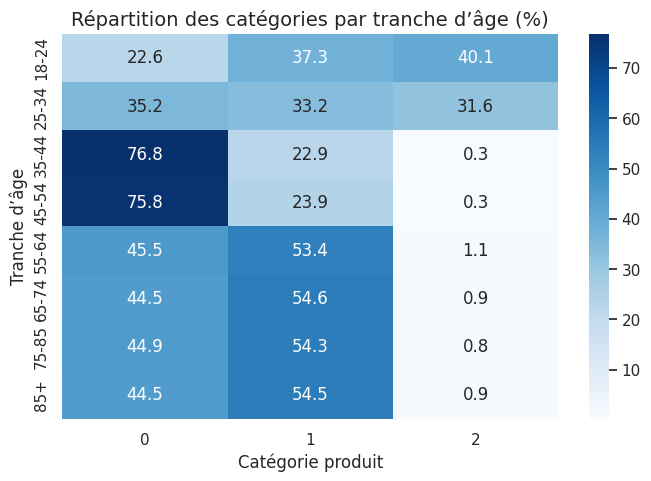

In [318]:
plt.figure(figsize=(8,5))
sns.heatmap(age_categ, annot=True, cmap="Blues", fmt=".1f")
plt.title("Répartition des catégories par tranche d’âge (%)")
plt.ylabel("Tranche d’âge")
plt.xlabel("Catégorie produit")
plt.show()

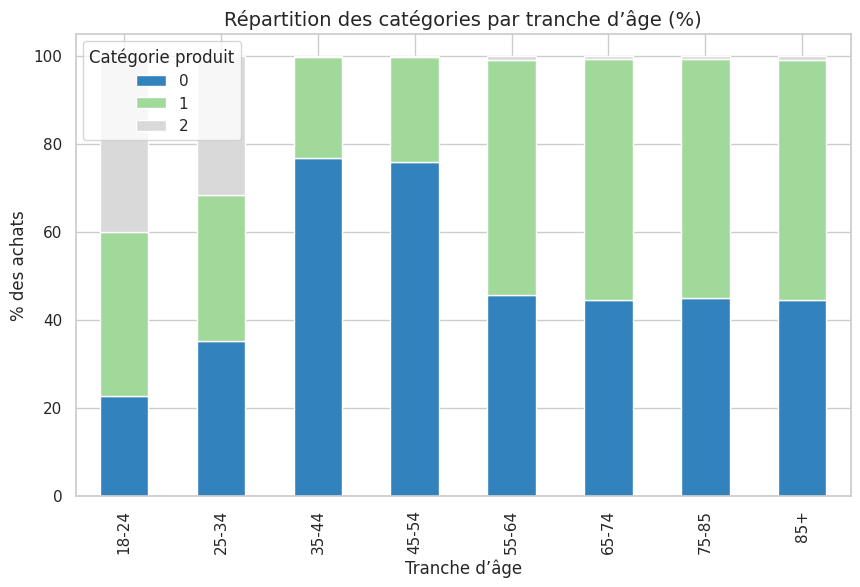

In [319]:
age_categ_plot = pd.crosstab(df_tf["tranche_age"], df_tf["categ"], normalize="index") * 100
age_categ_plot.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20c")

plt.title("Répartition des catégories par tranche d’âge (%)")
plt.ylabel("% des achats")
plt.xlabel("Tranche d’âge")
plt.legend(title="Catégorie produit")
plt.show()


On fait maintenant l'analyse par tranche d'age apres avoir répartie en groupe d'age.

In [320]:


# Créer les groupes à comparer
corr_age_cat = [df_tf.loc[df_tf["age"] == g, "categ"].dropna()
           for g in df_tf["age"].unique()]

# Test d’ANOVA
F, p = stats.f_oneway(*corr_age_cat)
print(f"F = {F:.3f}, p = {p:.3g}")


TypeError: unsupported operand type(s) for /: 'str' and 'int'

Test ANOVA sur age selon categ
F = 22711.789, p = 0
→ Différence significative entre au moins deux groupes.


/tmp/ipython-input-3446211244.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)


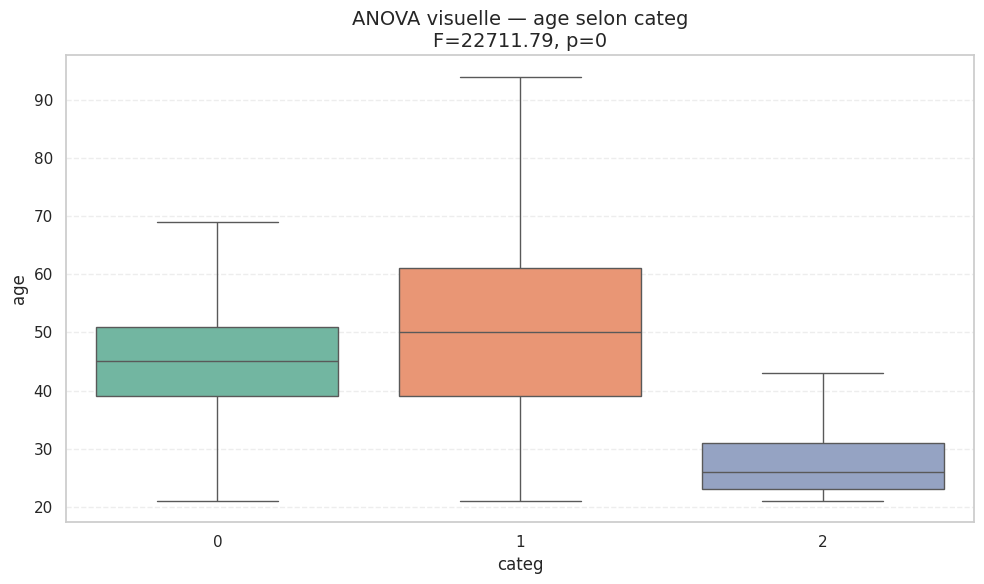

ω² = 0.119


In [325]:
# ============================
# TEST ANOVA
# ============================

# ====== Paramètres ======
X = "categ"      # variable qualitative (ex: catégorie)
Y = "age"        # variable quantitative (ex: âge)
df = df_tf.copy()

# ====== Préparation des données ======
# On garde seulement les colonnes utiles et on nettoie
df = df[[X, Y]].dropna().copy()
# Quali en 'category', Quanti en float
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# ====== ANOVA (scipy) ======
# Liste des groupes (valeurs de Y pour chaque modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# Vérif minimale (au moins 2 groupes non vides)
if len([g for g in groupes if len(g) > 0]) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes non vides.")

F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

# ====== ω² (omega carré) avec statsmodels ======
def omega_squared(df_in: pd.DataFrame, x: str, y: str) -> float:
    """
    Part de variance de y (quantitatif) expliquée par x (qualitatif), corrigée (ω²).
    """
    d = df_in[[x, y]].dropna().copy()
    d[x] = d[x].astype("category")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[y])

    model = ols(f"{y} ~ C({x})", data=d).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 robuste

    # Récupération SCE (between), SCT (total), MSE (résiduel)
    # La ligne du facteur est "C(x)" dans l'ANOVA typ=2
    factor_label = [idx for idx in anova_table.index if idx != "Residual"][0]
    SCE = anova_table.loc[factor_label, "sum_sq"]
    # MSE = SS_res / df_res
    SS_res = anova_table.loc["Residual", "sum_sq"]
    df_res = anova_table.loc["Residual", "df"]
    MSE = SS_res / df_res
    SCT = anova_table["sum_sq"].sum()

    omega2 = (SCE - (d[x].nunique() - 1) * MSE) / (SCT + MSE)
    return float(max(0.0, omega2))

omega = omega_squared(df, x=X, y=Y)
print(f"ω² = {omega:.3f}")

Un test d’ANOVA met en évidence une différence significative des âges moyens selon les catégories de produits (p < 0.001).
Le coefficient de corrélation η² = 0.119, corrigé par ω² = 0.119, indique qu’environ 12 % de la variance de l’âge des clients est expliquée par la catégorie de produit.

L’effet est statistiquement significatif mais de force modérée, suggérant que si la catégorie influence bien l’âge moyen des acheteurs, d’autres variables (comme le sexe, le revenu ou la fréquence d’achat) interviennent probablement de façon complémentaire.

**Interpretation**

##Corrélation entre age du client et prix du panier moyen (quanti quanti)

In [332]:
df_clients = panier_by_client.copy()

In [339]:
df_clients

,client_id,age,nb_achats,nb_produits,panier_moyen
0,c_1,70.00,15,20,1.33
1,c_10,69.00,16,28,1.75
2,c_100,33.00,3,6,2.00
3,c_1000,59.00,42,56,1.33
4,c_1001,43.00,24,58,2.42
...,...,...,...,...,...
8595,c_995,70.00,5,8,1.60
8596,c_996,55.00,36,42,1.17
8597,c_997,31.00,10,23,2.30
8598,c_998,24.00,13,28,2.15


Corrélation linéaire de Pearson : r = -0.228, p = 8.85e-102
Corrélation de Spearman : ρ = -0.221, p = 2.45e-95
Corrélation de Kendall : τ = -0.139, p = 1.31e-81


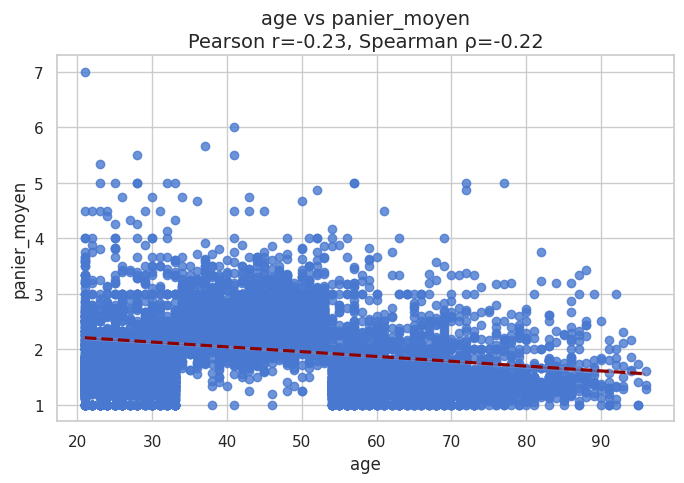

In [334]:
# ============================
# CORRÉLATION QUANTI - QUANTI
# ============================


X = "age"       # variable quantitative 1
Y = "panier_moyen"     # variable quantitative 2
df =  df_clients.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()


Il existe une légère tendance à la baisse du panier moyen avec l’âge, mais la corrélation est faible et non déterminante.
Autrement dit, l’âge influence peu le montant du panier : les clients jeunes comme âgés présentent une grande variabilité dans leurs dépenses moyennes.
D’autres variables (ex. catégorie de produit, fréquence d’achat, pouvoir d’achat, comportement client) expliquent probablement davantage la variation du panier moyen.

## Corrélation tranche d'age et prix du panier ( quanti - quali)

| Méthode                                     | Type de relation mesurée                                                  | Hypothèses statistiques                          | Interprétation                                                                                               |
| ------------------------------------------- | ------------------------------------------------------------------------- | ------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| **Eta carré (η²)**                          | **Part de variance expliquée** par la variable qualitative                | Homogénéité des variances (test ANOVA)           | Mesure la **force du lien** entre les groupes et la variable quantitative (0 → aucun lien, 1 → lien parfait) |
| **Omega carré (ω²)**                        | Variante corrigée et moins biaisée de η²                                  | Idem ANOVA                                       | Mesure la **part réelle** de variance expliquée, plus fiable sur petits échantillons                         |
| **Test ANOVA (F-test)**                     | Vérifie si les **moyennes** diffèrent significativement entre les groupes | Normalité des résidus, homogénéité des variances | Teste **l’existence d’un effet significatif** du facteur qualitatif sur la variable quantitative             |
| **Kruskal–Wallis (H-test)**                 | Version non paramétrique de l’ANOVA (pas de normalité requise)            | Aucune normalité requise                         | Compare les distributions de la variable quantitative entre les groupes                                      |
| **Boxplots par modalité**                   | Visualisation exploratoire                                                | Aucune hypothèse                                 | Permet de voir la **dispersion et les écarts** entre les groupes                                             |
| **Régression linéaire avec variable dummy** | Modélisation directionnelle (variable catégorielle → quantitati           |                                                  |                                                                                                              |


In [341]:
print(df_tf[["client_id", "panier_moyen"]].head())
print(df_tf["panier_moyen"].isna().mean()*100, "% de valeurs manquantes")


  client_id  panier_moyen
0    c_4450          2.27
1     c_277          2.00
2    c_4270          2.67
3    c_4597          1.00
4    c_1242          2.55
0.0 % de valeurs manquantes


Test ANOVA sur panier_moyen selon tranche_age
F = 28586.128, p = 0
→ Différence significative entre au moins deux groupes.
η² (eta carré) = 0.373


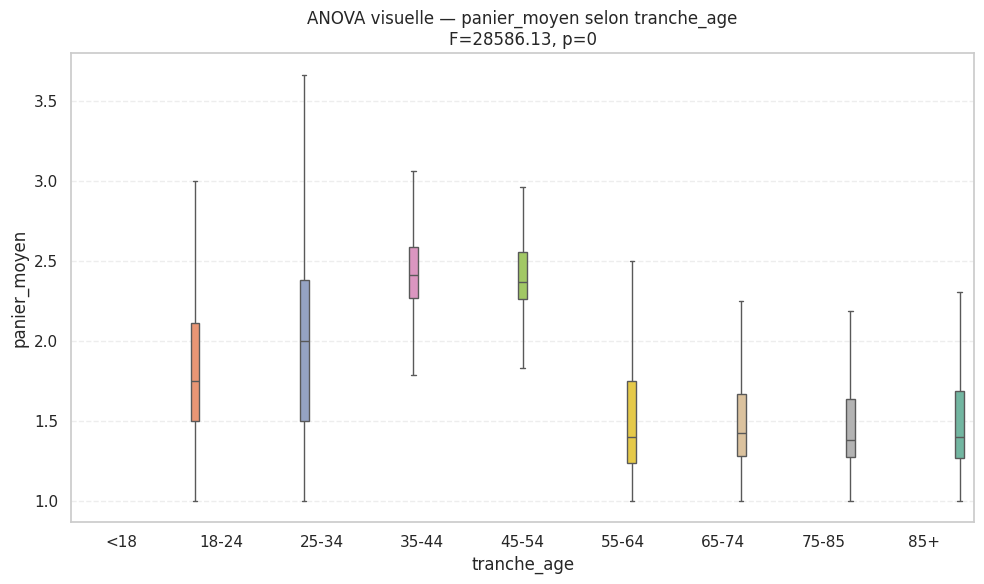

In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ============================
# PARAMÈTRES
# ============================
X = "tranche_age"          # variable qualitative
Y = "panier_moyen"          # variable quantitative
df = df_tf.copy()    # DataFrame de base

# ============================
# 1️⃣ Préparation des données
# ============================
df = df[[X, Y]].dropna().copy()
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# Liste des groupes (valeurs de Y par modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories if len(df.loc[df[X] == m, Y]) > 1]

if len(groupes) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes valides.")

# ============================
# 2️⃣ ANOVA (test de Fisher)
# ============================
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ============================
# 3️⃣ Effet de taille : η² (eta carré)
# ============================
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"η² (eta carré) = {eta2:.3f}")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, hue=X, palette="Set2", showfliers=False, legend=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()


L’analyse de variance (F = 28 586.13, p < 0.001) révèle une différence hautement significative du panier moyen selon les tranches d’âge.
L’effet de taille (η² = 0.373) indique que près de 37 % de la variance du panier moyen est expliquée par l’âge, ce qui constitue un effet fort.
Le montant du panier atteint un maximum chez les clients âgés de 35 à 50 ans, puis décroît progressivement après 55 ans.
Ces résultats suggèrent une tendance claire : les clients d’âge intermédiaire dépensent davantage par commande que les plus jeunes et les plus âgés.

In [347]:
# On garde seulement les tranches avec au moins 2 valeurs
valid_groups = df.groupby("tranche_age")["panier_moyen"].filter(lambda x: len(x) >= 2)
df_valid = df.loc[valid_groups.index]

# Relance le test ANOVA sur df_valid
groupes = [df_valid.loc[df_valid["tranche_age"] == m, "panier_moyen"].values
           for m in df_valid["tranche_age"].unique()]
F, p = stats.f_oneway(*groupes)
print(f"F = {F:.3f}, p = {p:.3g}")

F = 28586.128, p = 0


/tmp/ipython-input-1183759143.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_groups = df.groupby("tranche_age")["panier_moyen"].filter(lambda x: len(x) >= 2)


il doit y avoir des clients qui n'ont rien acheté, on a donc fait un filtre pour avoir uniquement les clients avec achat.

Test ANOVA sur panier_moyen selon tranche_age
F = 28586.128, p = 0
→ Différence significative entre au moins deux groupes.
η² (eta carré) = 0.373


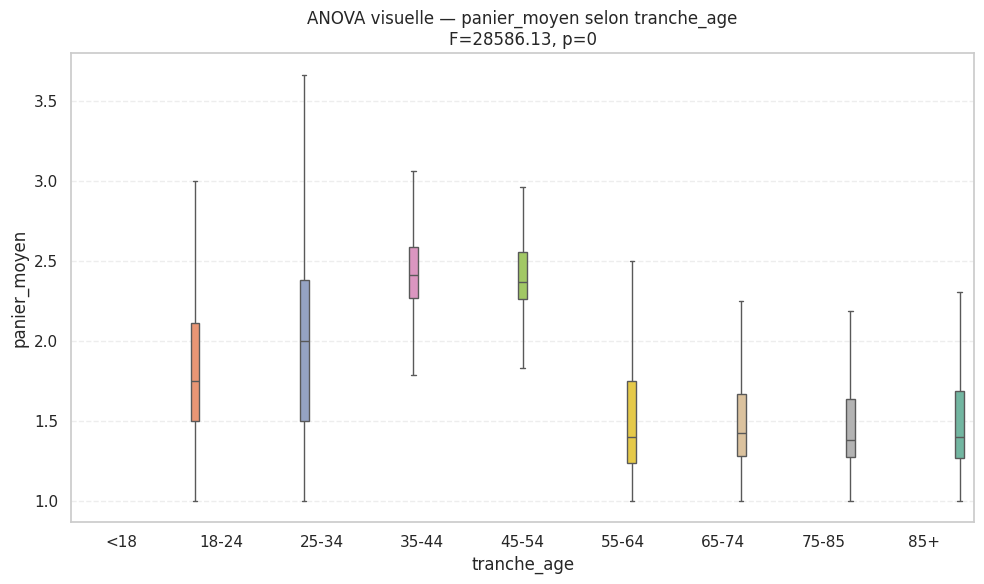

In [360]:
# Garde seulement les tranches avec au moins 2 obs.
valid_mask = (
    df.groupby("tranche_age", observed=True)["panier_moyen"]
      .transform("size") >= 2
)
df_valid = df.loc[valid_mask].copy()
# ============================
# PARAMÈTRES
# ============================
X = "tranche_age"          # variable qualitative
Y = "panier_moyen"          # variable quantitative
df = df_valid.copy()    # DataFrame de base

# ============================
# 1️⃣ Préparation des données
# ============================
df = df[[X, Y]].dropna().copy()
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# Liste des groupes (valeurs de Y par modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories if len(df.loc[df[X] == m, Y]) > 1]

if len(groupes) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes valides.")

# ============================
# 2️⃣ ANOVA (test de Fisher)
# ============================
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ============================
# 3️⃣ Effet de taille : η² (eta carré)
# ============================
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"η² (eta carré) = {eta2:.3f}")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, hue=X, palette="Set2", showfliers=False, legend=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

L’ANOVA confirme l’existence d’un effet très significatif de l’âge sur le panier moyen (p < 0.001).
Le test post-hoc de Tukey montre que cet effet se traduit par des différences systématiques entre les tranches d’âge, sauf entre les 65–74 ans et les 85 ans et plus.

La tendance générale observée est une diminution progressive du panier moyen avec l’âge :

Les 25–44 ans présentent les paniers les plus élevés ;

À partir de 55 ans, les paniers moyens chutent nettement ;

Les tranches seniors (65+) ont des comportements d’achat similaires entre elles.

In [349]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df_valid["panier_moyen"],
                          groups=df_valid["tranche_age"],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 18-24  25-34   0.1209    0.0   0.107  0.1348   True
 18-24  35-44   0.5474    0.0  0.5349  0.5599   True
 18-24  45-54   0.5045    0.0   0.492  0.5169   True
 18-24  55-64  -0.2068    0.0 -0.2202 -0.1934   True
 18-24  65-74  -0.3565    0.0  -0.371  -0.342   True
 18-24  75-85  -0.3814    0.0 -0.3993 -0.3634   True
 18-24    85+  -0.3506    0.0  -0.376 -0.3252   True
 25-34  35-44   0.4265    0.0  0.4179  0.4352   True
 25-34  45-54   0.3836    0.0   0.375  0.3922   True
 25-34  55-64  -0.3277    0.0 -0.3377 -0.3178   True
 25-34  65-74  -0.4774    0.0 -0.4887  -0.466   True
 25-34  75-85  -0.5022    0.0 -0.5178 -0.4867   True
 25-34    85+  -0.4715    0.0 -0.4952 -0.4477   True
 35-44  45-54  -0.0429    0.0  -0.049 -0.0369   True
 35-44  55-64  -0.7542    0.0 -0.7621 -0.7464   True
 35-44  65-74  -0.9039    0.0 -0.9135 -0.8943 

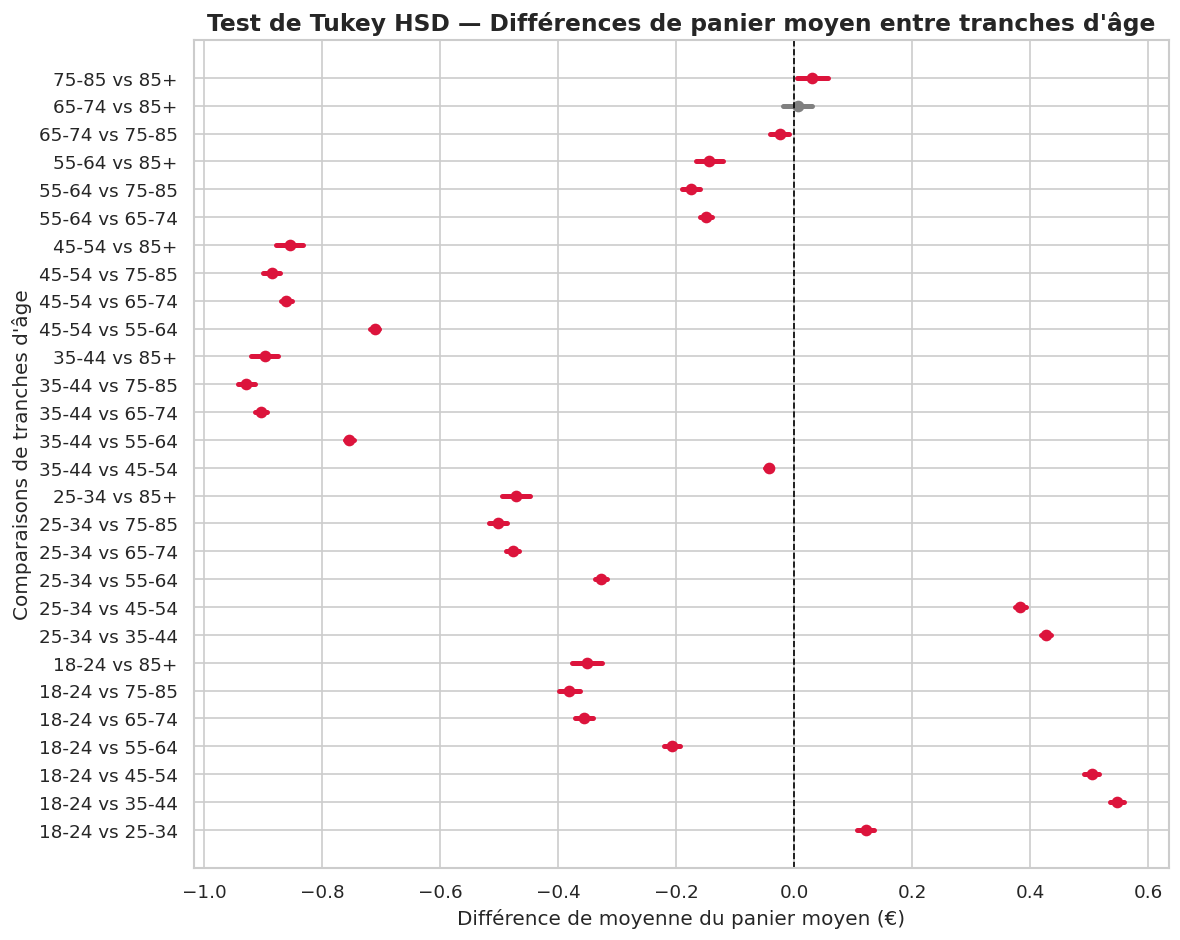

In [350]:
# Convertir les résultats en DataFrame pour faciliter la visualisation
tukey_df = pd.DataFrame(
    data=tukey._results_table.data[1:],
    columns=tukey._results_table.data[0]
)

# --- 2️⃣ Création du graphique des intervalles de confiance ---
plt.figure(figsize=(10, 8), dpi=120)
sns.set(style="whitegrid")

# Tracé horizontal des intervalles de confiance
for i, row in tukey_df.iterrows():
    plt.plot(
        [row["lower"], row["upper"]],   # borne inférieure et supérieure
        [i, i],                         # position sur l'axe Y
        color="gray" if not row["reject"] else "crimson",
        lw=3
    )
    plt.plot(row["meandiff"], i, "o",
             color="crimson" if row["reject"] else "gray")

# --- 3️⃣ Personnalisation du graphique ---
plt.yticks(range(len(tukey_df)), tukey_df.apply(lambda r: f"{r['group1']} vs {r['group2']}", axis=1))
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.title("Test de Tukey HSD — Différences de panier moyen entre tranches d'âge", fontsize=14, weight="bold")
plt.xlabel("Différence de moyenne du panier moyen (€)")
plt.ylabel("Comparaisons de tranches d'âge")
plt.tight_layout()
plt.show()

L’analyse de variance (F = 28 586, p < 0.001) met en évidence une différence significative de panier moyen selon la tranche d’âge.
Le test de Tukey HSD confirme que ces différences concernent la quasi-totalité des tranches, à l’exception des plus âgées (65–85+), dont les comportements d’achat sont homogènes.
Le panier moyen décroît de façon régulière avec l’âge, suggérant un effet générationnel marqué sur la propension à dépenser.

| Objectif                                      | Test à réaliser                                     |
| --------------------------------------------- | --------------------------------------------------------- |
| **Tester si les groupes diffèrent entre eux** | ANOVA ou Kruskal–Wallis                                   |
| **Mesurer la part de variance expliquée**     | η² ou ω²                                                  |
| **Visualiser les différences**                | Boxplots par catégorie                                    |
| **Modéliser / prédire**                       | Régression linéaire avec variables indicatrices (dummies) |


In [ ]:
# ====== Paramètres ======
X = "categ"      # variable qualitative (ex: catégorie)
Y = "age"        # variable quantitative (ex: âge)
df = df_tf.copy()

# ====== Préparation des données ======
# On garde seulement les colonnes utiles et on nettoie
df = df[[X, Y]].dropna().copy()
# Quali en 'category', Quanti en float
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# ====== ANOVA (scipy) ======
# Liste des groupes (valeurs de Y pour chaque modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# Vérif minimale (au moins 2 groupes non vides)
if len([g for g in groupes if len(g) > 0]) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes non vides.")

F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

# ====== ω² (omega carré) avec statsmodels ======
def omega_squared(df_in: pd.DataFrame, x: str, y: str) -> float:
    """
    Part de variance de y (quantitatif) expliquée par x (qualitatif), corrigée (ω²).
    """
    d = df_in[[x, y]].dropna().copy()
    d[x] = d[x].astype("category")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[y])

    model = ols(f"{y} ~ C({x})", data=d).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 robuste

    # Récupération SCE (between), SCT (total), MSE (résiduel)
    # La ligne du facteur est "C(x)" dans l'ANOVA typ=2
    factor_label = [idx for idx in anova_table.index if idx != "Residual"][0]
    SCE = anova_table.loc[factor_label, "sum_sq"]
    # MSE = SS_res / df_res
    SS_res = anova_table.loc["Residual", "sum_sq"]
    df_res = anova_table.loc["Residual", "df"]
    MSE = SS_res / df_res
    SCT = anova_table["sum_sq"].sum()

    omega2 = (SCE - (d[x].nunique() - 1) * MSE) / (SCT + MSE)
    return float(max(0.0, omega2))

omega = omega_squared(df, x=X, y=Y)
print(f"ω² = {omega:.3f}")

In [ ]:


# Créer les groupes à comparer
groupes = [df_clients.loc[df_clients["age_group"] == g, "panier_moyen"].dropna()
           for g in df_clients["age_group"].unique()]

# Test d’ANOVA
F, p = stats.f_oneway(*groupes)
print(f"F = {F:.3f}, p = {p:.3g}")


In [ ]:
df_clients["age_group"] = df_tf['tranche_age']

In [ ]:
print(f"ANOVA F={res['anova_F']:.2f}, p={res['anova_p']:.3g} | η²={res['eta2']:.3f}, ω²={res['omega2']:.3f} | n={res['n']}")

In [ ]:
from scipy.stats import pearsonr

r, p = pearsonr(df_clients["age"], df_clients["panier_moyen"])
print(f"Corrélation de Pearson : r = {r:.3f}, p = {p:.3g}")


In [ ]:
Montant_Total_Client_Groupe  = df_tf.copy()

In [ ]:
Montant_Total_Client_Groupe ["age"] = df_tf["age"].astype(float)
Montant_Total_Client_Groupe = df_tf.groupby(['client_id', 'tranche_age']).sum()
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.rename(columns={'price':'Montant Total'})
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.reset_index()


In [ ]:
Montant_Total_Client_Groupe.info()

In [ ]:
# 1) Agrégation : ne sommer que 'price'
Montant_Total_Client_Groupe = (
    df_tfc
      .groupby(['client_id', 'age'], observed=True)['price']
      .sum()
      .reset_index(name='Montant Total')
)

# 2) Boxplot par modalité d’âge — plus simple avec seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(
    data=Montant_Total_Client_Groupe,
    x='age', y='Montant Total',
    showfliers=False
)
plt.title("Distribution du montant total des achats par groupe d’âge")
plt.xlabel("Groupe d’âge")
plt.ylabel("Montant (en €)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# 1) Agrégation : ne sommer que 'price'
Montant_Total_Client_Groupe = (
    df_tf
      .groupby(['client_id', 'tranche_age'], observed=True)['price']
      .sum()
      .reset_index(name='Montant Total')
)

# 2) Boxplot par modalité d’âge — plus simple avec seaborn

plt.figure(figsize=(10,6))
sns.boxplot(
    data=Montant_Total_Client_Groupe,
    x='tranche_age', y='Montant Total',
    showfliers=False
)
plt.title("Distribution du montant total des achats par groupe d’âge")
plt.xlabel("Groupe d’âge")
plt.ylabel("Montant (en €)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
Montant_Total_Client_Groupe = df_tf.groupby(['client_id', 'age']).sum()
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.rename(columns={'price':'Montant Total'})
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.reset_index()



X = "age" # qualitative
Y = "Montant Total" # quantitative
modalites = Montant_Total_Client_Groupe[X].unique()
groupes = []
for m in modalites:
    groupes.append(Montant_Total_Client_Groupe[Montant_Total_Client_Groupe[X]==m][Y])

# Propriétés graphiques (pas très importantes)
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops,
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Distribution du montant total des achat par groupe d'age")
plt.ylabel("Montant (en €)")
plt.xlabel("Groupe d'Age")
plt.show()

In [ ]:
df_tf.head(2)

In [ ]:
# ============================
# CORRÉLATION QUANTI - QUANTI
# ============================


X = "age"       # variable quantitative 1
Y = "montant_total_session"     # variable quantitative 2
df =  df_tf.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()


In [ ]:
# ============================
# ANOVA + ETA² — QUALI / QUANTI
# ============================

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X = "categ"      # variable qualitative
Y = "price"      # variable quantitative
df = df_tf.copy()

# 1️⃣ Nettoyage et typage
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")

# 2️⃣ Préparation des groupes
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# 3️⃣ Test ANOVA
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")

# 4️⃣ Calcul de l’Eta²
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"→ Eta² = {eta2:.3f}")

# 5️⃣ Interprétation
if p < 0.05:
    print("→ Différence significative entre au moins deux groupes.")
else:
    print("→ Aucune différence significative détectée.")

# 6️⃣ Visualisation
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)
plt.title(f"ANOVA — {Y} selon {X}\nF={F:.2f}, p={p:.3g}, η²={eta2:.2f}")
plt.tight_layout()
plt.show()


In [ ]:
# ============================
# KHI-2 + CRAMER’S V — QUALI / QUALI
# ============================

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

X = "sex"       # variable qualitative 1
Y = "categ"     # variable qualitative 2
df = df_tf.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")
df[Y] = df[Y].astype("category")

# 2️⃣ Table de contingence
ct = pd.crosstab(df[X], df[Y])

# 3️⃣ Test du Khi-2
chi2, p, dof, expected = stats.chi2_contingency(ct)
n = ct.to_numpy().sum()
r, c = ct.shape
cramers_v = np.sqrt(chi2 / (n * (min(r, c) - 1)))

# 4️⃣ Résultats
print(f"Khi² = {chi2:.3f}, ddl = {dof}, p = {p:.3g}")
print(f"Cramer’s V = {cramers_v:.3f}")

if p < 0.05:
    print("→ Association significative entre les deux variables.")
else:
    print("→ Aucune association significative détectée.")

# 5️⃣ Visualisation
contrib = (ct - expected)**2 / expected
rel = contrib / contrib.to_numpy().sum()

plt.figure(figsize=(6,5))
sns.heatmap(rel, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Association {X} ↔ {Y}\nχ²={chi2:.1f}, p={p:.3g}, V={cramers_v:.2f}")
plt.tight_layout()
plt.show()
